# BUSINESS PROBLEM
There are growing implications surrounding generative AI in the speech domain that enable voice cloning and real-time voice conversion from one individual to another. This technology poses a significant ethical threat and could lead to breaches of privacy and misrepresentation, thus there is an urgent need for real-time detection of AI-generated speech for DeepFake Voice Conversion.

To address the above emerging issues, we are introducing the DEEP-VOICE dataset. DEEP-VOICE is comprised of real human speech from eight well-known figures and their speech converted to one another using Retrieval-based Voice Conversion.

For each speech, the accompaniment ("background noise") was removed before conversion using RVC. The original accompaniment is then added back to the DeepFake speech:
                                 
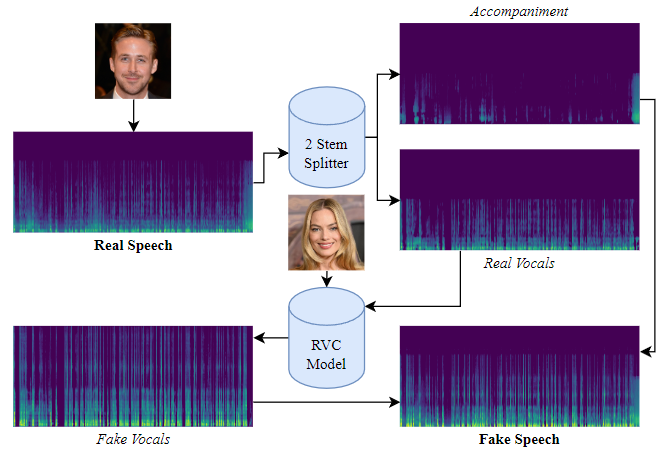

(Above: Overview of the Retrieval-based Voice Conversion process to generate DeepFake speech with Ryan Gosling's speech converted to Margot Robbie. Conversion is run on the extracted vocals before being layered on the original background ambience.)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import librosa
import IPython
from tqdm import tqdm
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Dataset
There are two forms to the dataset that was made available.

First, the raw audio can be found in the "AUDIO" directory. They are arranged within "REAL" and "FAKE" class directories. The audio filenames note which speakers provided the real speech, and which voices they were converted to. For example "Obama-to-Biden" denotes that Barack Obama's speech has been converted to Joe Biden's voice.

Second, the extracted features can be found in the "DATASET-balanced.csv" file. This is the data that was used in the below study. The dataset has each feature extracted from one-second windows of audio and are balanced through random sampling.

A potential use of a successful system could be used for the following:

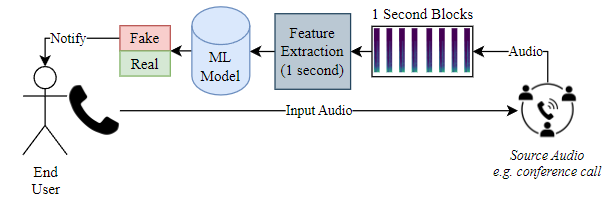

Usage of the real-time system. The end user is notified when the machine learning model has processed the speech audio (e.g. a phone or conference call) and predicted that audio chunks contain AI-generated speech.

(Above: Usage of the real-time system. The end user is notified when the machine learning model has processed the speech audio (e.g. a phone or conference call) and predicted that audio chunks contain AI-generated speech.)

In [2]:
df = pd.read_csv('DATASET-balanced.csv')
df.head()

chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0 -6.686564  0.902086 -7.251551 -1.198342  4.747403 -4.986279  0.953935   
1 -2.131157 -6.876417 -1.359395  0.326401 -5.420016 -2.109968 -1.757634   
2 -5.853725 -3.724773 -6.627182 -5.117002 -6.072106 -0.994653 -1.617120   
3 -1.898315 -2.046493 -7.176277 -3.293508  4.209121  0.121835 -5.407063   
4 -1.952340  0.810868  6.238493  6.555839  7.535542  2.849219  2.616843   

     mfcc19    mfcc20  LABEL  
0 -5.013138 -6.779060   FAKE  
1 -9.537907 -8.494421   FAKE  
2 -3.922354 -7.033001   FAKE  
3 -3.654926 -3.274857   FAKE  
4 -1.793357 -5.060998   FAKE  

[5 rows x 27 columns]

# DATA UNDERSTANDING
1. **chroma_stft(Chroma Short-Time Fourier Transform) :**
   - Measures the energy distribution across different pitch classes (chromas) in the short-time Fourier transform (STFT).
   - Captures harmonic and pitch-related characteristics.
   - Fake voices might have different pitch distributions due to synthetic generation.
   - It helps capture tonal information in an audio signal.
2. **rms :** 
   - Root Mean Square (RMS) energy of the signal, representing the loudness of the audio.
   - Fake voices might exhibit unnatural energy variations or smooth energy curves.
3. **spectral_centroid :** 
   - The center of mass of the spectrum, indicating the perceived brightness of a sound.
   - Fake voices might exhibit unnatural energy variations or smooth energy curves.
4. **spectral_bandwidth :** 
   - Measures the width of the spectrum, showing the spread of frequencies around the centroid.
   - Fake voices might have unnatural bandwidth characteristics due to limited frequency variability.
5. **rolloff :** 
   - The frequency below which a certain percentage (typically 85-95%) of the total spectral energy is contained, used to distinguish between different sound textures.
   - Indicates where most of the spectral energy is concentrated.
   - Fake voices might have a sharper or flatter rolloff due to different synthesis techniques.
6. **zero_crossing_rate :** 
   - The rate at which the signal changes from positive to negative, often used to differentiate between voiced and unvoiced sounds.
   - Higher ZCR can indicate more noisy or artificial signals.
7. **mfcc1 to mfcc20 :** 
   - Mel-Frequency Cepstral Coefficients (MFCCs), which represent the spectral characteristics of the audio signal.
   - Extracts key spectral features of the sound, mimicking human auditory perception.
   - Fake voices might have inconsistent MFCC patterns due to synthetic audio synthesis.
   - They are commonly used in speech and audio classification tasks.
8. **LABEL :** 
   - The target variable, indicating whether the voice is real or fake.
### How These Features Help in Fake Voice Detection
- **Natural vs. Synthesized Speech :** Fake voices often lack the natural variations in pitch, spectral energy, and timbre that real human speech has.
- **Artifacts in Synthetic Voices :** AI-generated voices may introduce unnatural smoothness or jitter in frequency-based features like spectral centroid and rolloff.
- **Energy & Pitch Irregularities :** Fake voices might have flatter energy distributions or unusual variations in zero-crossing rate.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11778 entries, 0 to 11777
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         11778 non-null  float64
 1   rms                 11778 non-null  float64
 2   spectral_centroid   11778 non-null  float64
 3   spectral_bandwidth  11778 non-null  float64
 4   rolloff             11778 non-null  float64
 5   zero_crossing_rate  11778 non-null  float64
 6   mfcc1               11778 non-null  float64
 7   mfcc2               11778 non-null  float64
 8   mfcc3               11778 non-null  float64
 9   mfcc4               11778 non-null  float64
 10  mfcc5               11778 non-null  float64
 11  mfcc6               11778 non-null  float64
 12  mfcc7               11778 non-null  float64
 13  mfcc8               11778 non-null  float64
 14  mfcc9               11778 non-null  float64
 15  mfcc10              11778 non-null  float64
 16  mfcc

In [4]:
df.isnull().sum()

chroma_stft           0
rms                   0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
LABEL                 0
dtype: int64

In [5]:
df.duplicated().sum()

0

# DATA EXPLORATION

In [6]:
audio_files_path = "AUDIO"
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [7]:
real_audio = "DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "DEMONSTRATION/linus-to-musk-DEMO.mp3"

In [8]:
print("Real Audio:")
IPython.display.Audio(real_audio)

Real Audio:


In [9]:
print("Fake Audio:")
IPython.display.Audio(fake_audio)

Fake Audio:


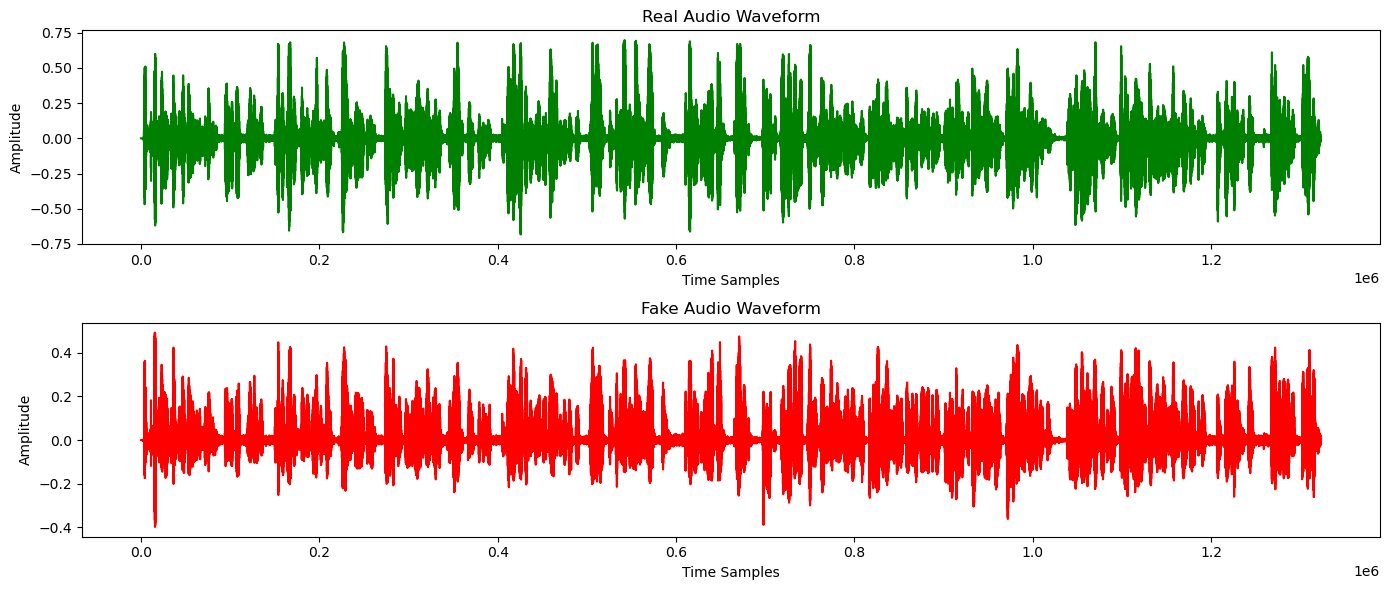

In [10]:
real_ad, real_sr = librosa.load(real_audio)
fake_ad, fake_sr = librosa.load(fake_audio)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(real_ad, color="green")
plt.title("Real Audio Waveform")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(fake_ad, color="red")
plt.title("Fake Audio Waveform")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### **Key Observations :**
#### **1️. Differences in Amplitude Patterns**
- **Real Audio (Top, Green)**
  - Shows a more natural variation in amplitude.
  - Energy distribution appears more smooth and organic, reflecting real speech dynamics.
  - Quiet sections (pauses) and high-intensity peaks appear more structured.
- **Fake Audio (Bottom, Red)**
  - Seems to have more consistent energy throughout.
  - May have less variation in amplitude, indicating a synthetic or generated nature.
  - If it was generated using AI (e.g., text-to-speech), it might lack natural pauses and dynamics.
#### **2️. Silence & Noise Patterns**
- **Real Speech :** Natural speech has moments of silence or lower amplitude (e.g., pauses between words).
- **Fake Speech :** Synthetic speech may not have these natural pauses and could look more "dense."
#### **3️. Signal Peaks & Dynamics**
- The real waveform exhibits strong peaks and variations, indicating natural speech modulation.
- The fake waveform may have less variation, which can be a sign of AI-generated speech lacking human expressiveness.

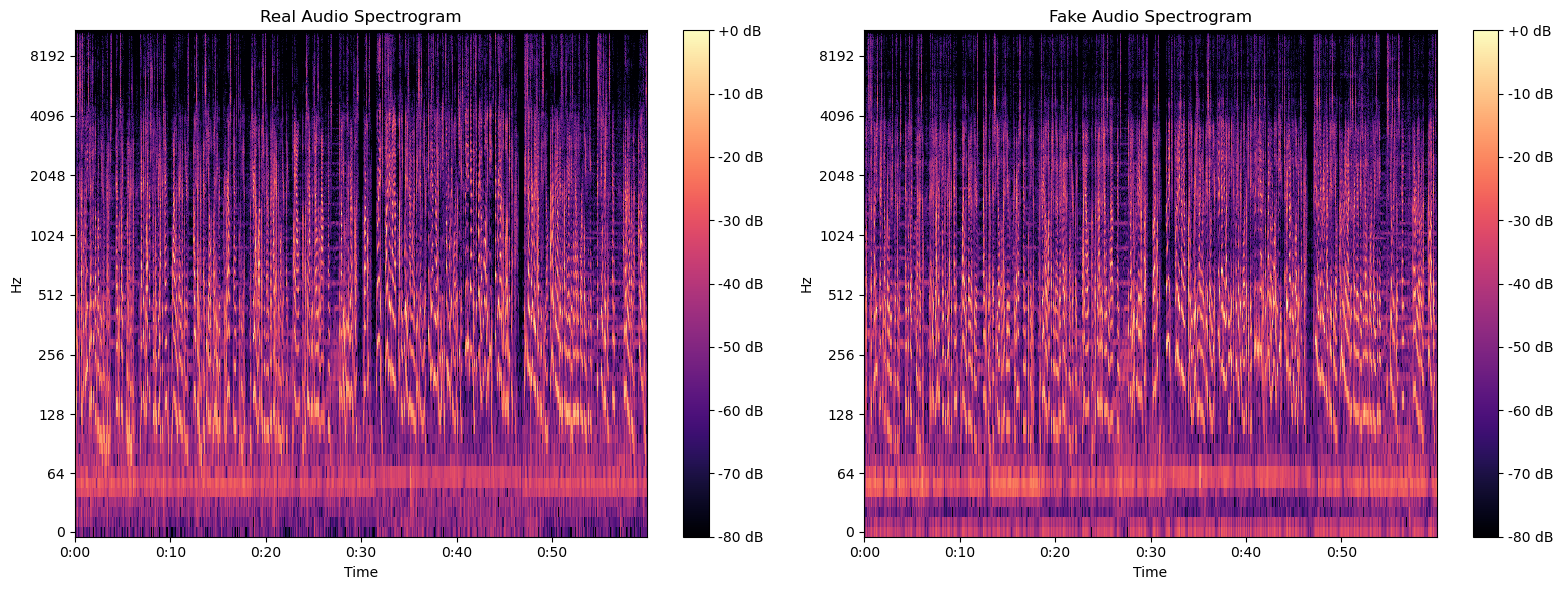

In [11]:
real_spec = np.abs(librosa.stft(real_ad))
fake_spec = np.abs(librosa.stft(fake_ad))

real_spec_db = librosa.amplitude_to_db(real_spec, ref=np.max)
fake_spec_db = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(real_spec_db, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectrogram")

plt.subplot(1, 2, 2)
librosa.display.specshow(fake_spec_db, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectrogram")

plt.tight_layout()
plt.show()

1. **Frequency Distribution Analysis**
   - Both spectrograms display frequencies on the vertical axis (Hz) and time on the horizontal axis.
   - The color intensity represents amplitude (dB), where brighter colors indicate higher energy.
   - Real audio appears to have a more natural and continuous frequency distribution.
   - Fake audio exhibits slight distortions, with possible artifacts or unnatural intensities in certain frequency bands.
2. **Low-Frequency Components**
   - Around 64 Hz, both spectrograms have strong intensities (orange-red color), which may represent the fundamental frequency of speech or background noise.
   - The fake audio might have stronger low-frequency bands, suggesting synthesized elements or frequency manipulation.
3. **Mid and High-Frequency Differences**
   - **Real audio :** Shows more intricate patterns in higher frequencies (above 1024 Hz), indicating richer harmonic content.
   - **Fake audio :** Might have a smoother or slightly altered texture, possibly due to compression or generative artifacts.
4. **Noise and Artifacts**
   - The fake spectrogram might exhibit artificial patterns, which can be a key indicator of synthetic speech or voice cloning techniques.
   - Real audio appears more continuous, while fake audio might have unnatural breaks or repetitions in specific frequency bands.
5. **Speech and Voice Characteristics**
   - Real speech often has natural variations in pitch and intensity.
   - Fake speech might have a more uniform intensity due to synthesis methods like text-to-speech (TTS) or AI-generated voices.

**The fake spectrogram seems visually similar to the real one but has subtle differences in frequency intensity, distribution, and potential artifacts.**

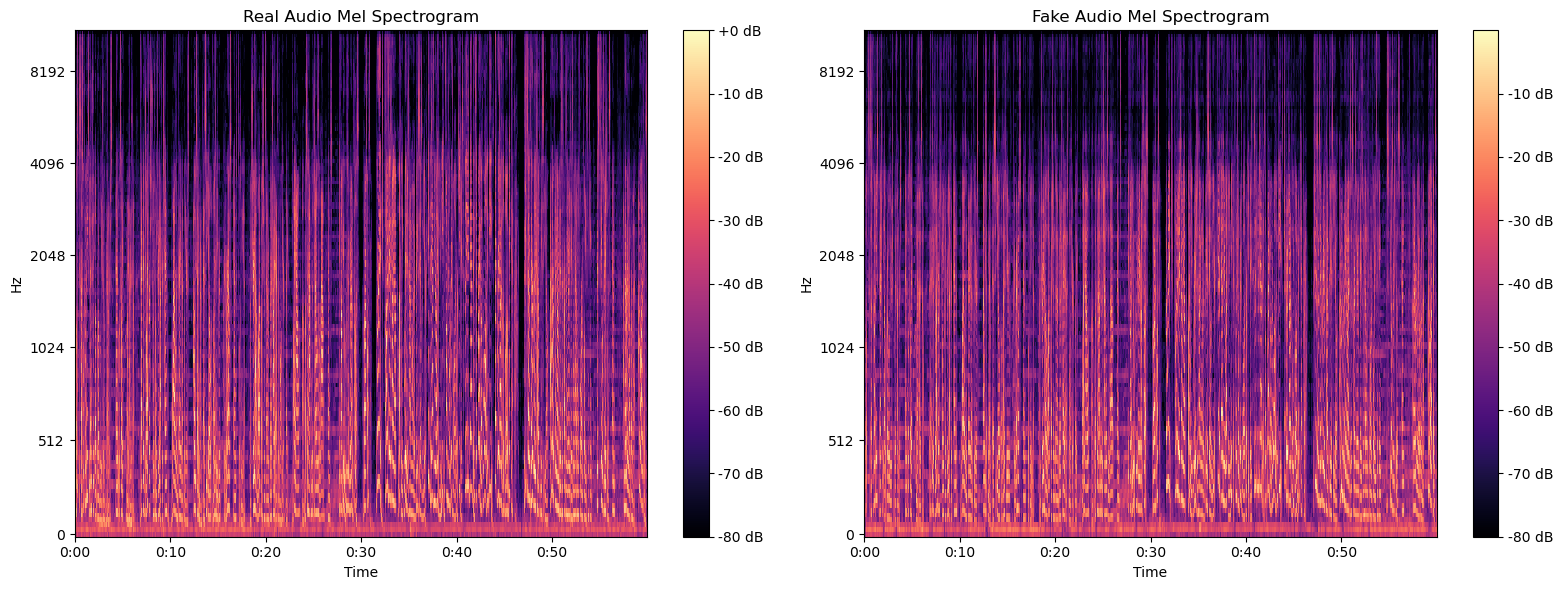

In [12]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)

real_mel_spect_db = librosa.power_to_db(real_mel_spect, ref=np.max)
fake_mel_spect_db = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
librosa.display.specshow(real_mel_spect_db, sr=real_sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Mel Spectrogram")

plt.subplot(1, 2, 2)
librosa.display.specshow(fake_mel_spect_db, sr=fake_sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Mel Spectrogram")

plt.tight_layout()
plt.show()

**A Mel spectrogram transforms an audio signal into the Mel scale, which better represents human perception by emphasizing low-frequency components.**
1. **Frequency Representation & Distribution**
   - **Real Audio :**
     - Richer, more diverse frequency components.
     - Smooth transitions between frequencies, suggesting natural voice production.
   - **Fake Audio :**
     - Slightly sparser high-frequency components (above 2048 Hz).
     - Potentially more uniform spectral patterns, possibly due to TTS (Text-to-Speech) generation or voice cloning artifacts.
2. **Energy and Intensity Differences**
   - **Real Audio :**
     - Displays more irregular intensity variations across time.
     - Shows natural variations in loudness, indicating more expressive speech.
   - **Fake Audio :**
     - More uniform intensity, which can indicate AI-generated or synthesized speech.
     - Some regions appear less dynamic, suggesting artificial smoothing or limited pitch modulation.
3. **High-Frequency Attenuation**
   - The Fake Audio Mel Spectrogram shows weaker high-frequency energy (above 4096 Hz).
   - This is common in AI-generated voices, as many models struggle to replicate high-frequency phonetic nuances present in real speech.
   - Real voices tend to maintain stronger high-frequency harmonics, contributing to more natural vocal timbre.
4. **Artifacts & Synthetic Patterns**
   - The Fake Audio Spectrogram might contain horizontal bands or repetitive frequency structures, which are characteristic of synthesized speech.
   - Real speech tends to have more continuous spectral changes rather than repeated, block-like patterns.

**Conclusion :**
- Real audio has richer harmonics, dynamic energy, and natural variations in intensity and frequency.
- Fake audio tends to have uniform intensity, high-frequency loss, and possible artifacts, suggesting synthetic generation.
- These differences are critical for deepfake detection, speech verification, and forensic analysis.

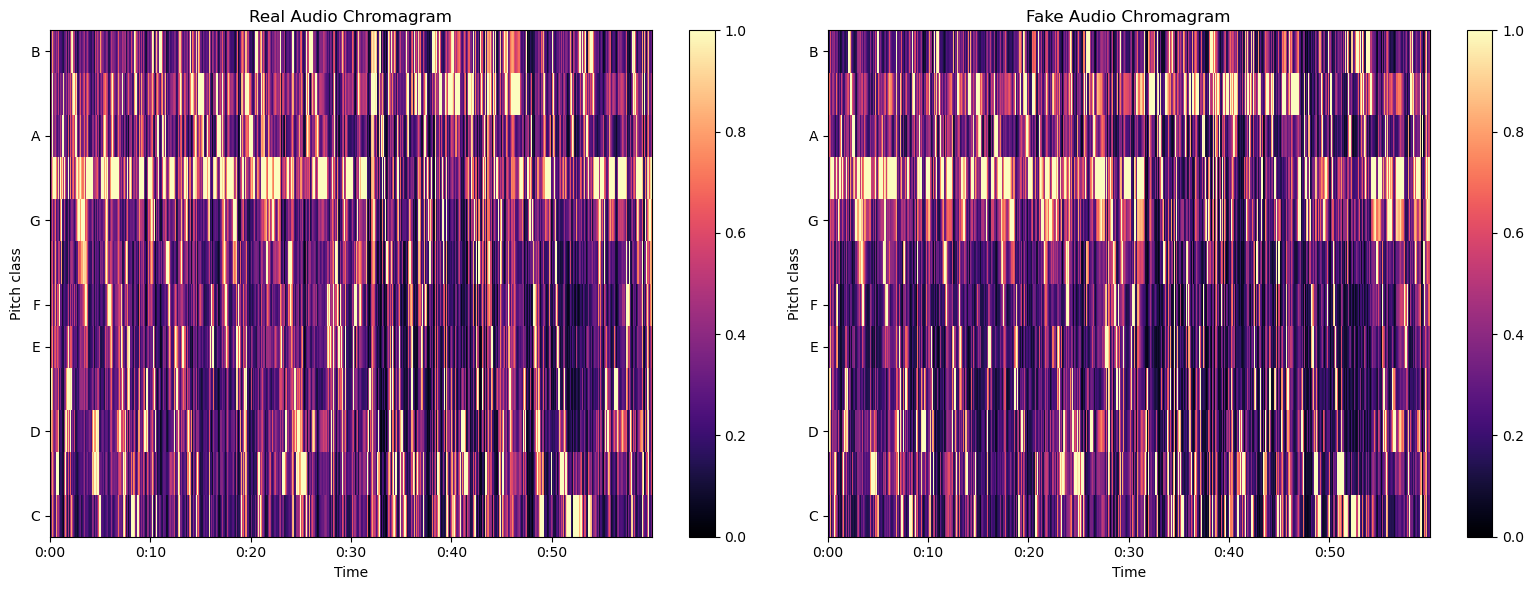

In [13]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")

plt.subplot(1, 2, 2)
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")

plt.tight_layout()
plt.show()

**A Chromagram represents the distribution of pitch classes (C, C#, D, etc.) over time, highlighting harmonic and melodic structures. This is useful in music analysis, speech processing, and deepfake detection.**
1. **Harmonic Consistency & Pitch Distribution**
   - **Real Audio :**
     - Shows distinct pitch variations across time.
     - Some strong, stable pitch activations (especially in A and G).
     - More irregularity, reflecting natural vocal dynamics.
   - **Fake Audio :**
     - More evenly spread energy across pitch classes (smoother appearance).
     - Some frequencies appear unnaturally consistent, possibly indicating TTS-generated content.
     - Less harmonic richness, suggesting reduced pitch modulation.
2. **Variability in Pitch Transitions**
   - **Real Audio :**
     - Frequent, irregular jumps between pitch classes, which is expected in natural speech and expressive singing.
     - More intermittent silences (black regions), suggesting natural pauses in vocalization.
   - **Fake Audio :**
     - More structured and less chaotic pitch transitions, possibly due to synthesis constraints.
     - Fewer black regions, indicating a lack of natural pauses or continuous speech patterns from synthetic generation.
3. **Timbre and Expressiveness Differences**
   - **Real Audio :**
     - Strong contrast between bright and dark regions, indicating dynamic vocal expressiveness.
     - More variation in pitch intensity, showing natural emotional fluctuations.
   - **Fake Audio :**
     - Uniform intensity across pitch classes, which suggests artificial smoothness.
     - Lacks expressive variations, making it sound more robotic or monotonous.

**Conclusion :**
- Real audio exhibits diverse harmonic structures, natural pitch variations, and expressive modulations.
- Fake audio tends to have smoother, more uniform pitch activations, fewer pauses, and reduced expressive contrast.
- These differences can be crucial for deepfake detection, AI-generated speech analysis, and forensic audio verification.

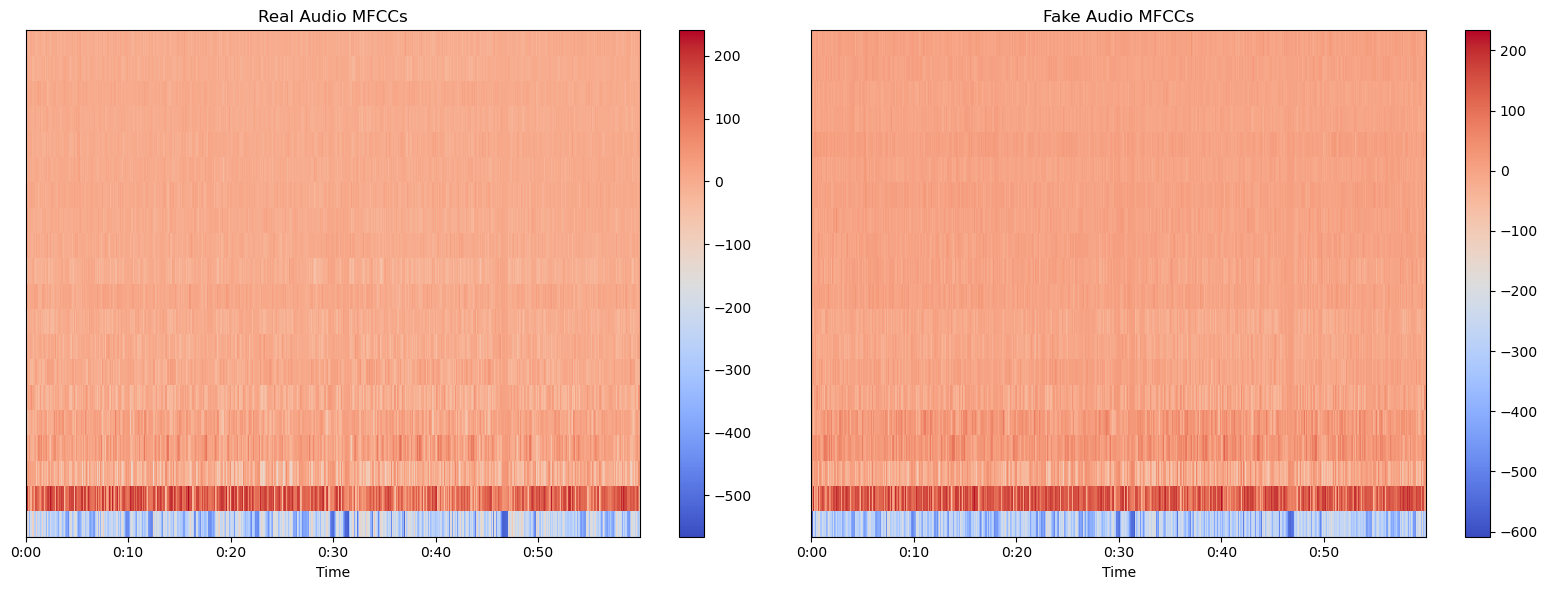

In [14]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio MFCCs")

plt.subplot(1, 2, 2)
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio MFCCs")

plt.tight_layout()
plt.show()

**MFCCs are widely used in speech and audio analysis as they capture timbre, phonetic structure, and spectral characteristics. They help differentiate natural and synthetic speech.**
1. **Spectral Consistency & Smoothness**
   - **Real Audio :**
     - Shows visible fluctuations across time and frequency.
     - More variation in brightness (color changes), indicating diverse phonetic content.
     - The lower frequency bands (bottom rows) have stronger negative values (blue regions), which are naturally occurring silences and energy drops in speech.
   - **Fake Audio :**
     - Appears smoother and more uniform in comparison.
     - Lacks strong variations in frequency components over time, suggesting less expressive dynamics.
     - The blue (low energy) regions at the bottom appear less frequent, meaning synthetic speech lacks natural pauses or energy drops.
2. **Low-Frequency Region Analysis (Bottom Rows)**
   - **Real Audio :**
     - More distinct blue and red bands, indicating natural resonance and formant shifts.
     - Captures speaker-specific characteristics (e.g., emotional tone, speaking style).
   - **Fake Audio :**
     - Weaker blue variations, meaning the low-frequency components are more uniform.
     - Suggests that the fake audio model fails to replicate subtle voice inflections, making it sound more robotic.
3. **Speech Expressiveness and Phoneme Transitions**
   - **Real Audio :**
     - Shows higher variability in the intensity of MFCC values.
     - Captures natural speech dynamics, including stress and articulation.
   - **Fake Audio :**
     - More homogeneous MFCCs, indicating lack of natural phoneme variation.
     - Suggests a monotonous, less expressive tone, which is typical of AI-generated voices.

**Conclusion :**
- Real Audio MFCCs show greater variation, phoneme richness, and expressive fluctuations.
- Fake Audio MFCCs appear smoother, with fewer fluctuations and less natural energy decay.
- These differences can be critical for detecting deepfake voices and synthetic speech models.

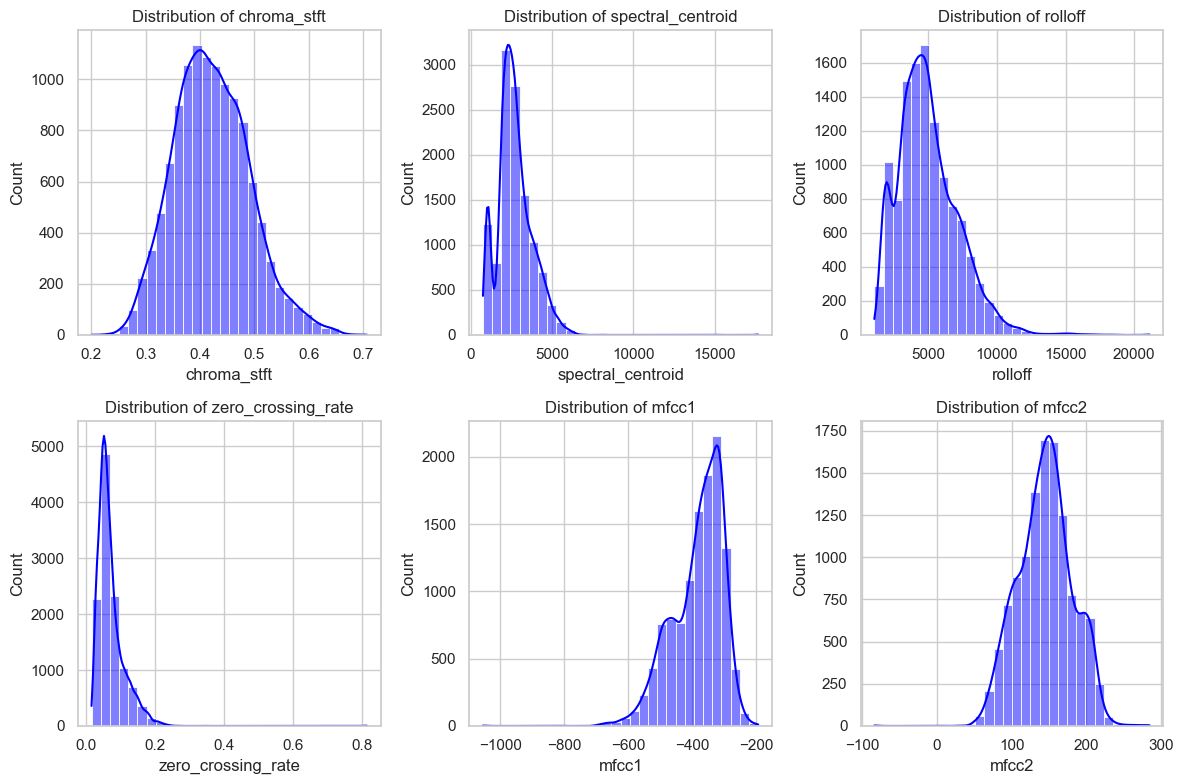

In [15]:
sns.set(style="whitegrid")
selected_features = ["chroma_stft", "spectral_centroid", "rolloff", "zero_crossing_rate", "mfcc1", "mfcc2"]
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], bins=30, kde=True, color="blue")
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

- **Chroma_stft follows a normal distribution.**
- **Spectral_centroid and rolloff are right-skewed, indicating that most values are concentrated in the lower range.**
- **Zero_crossing_rate is heavily right-skewed, with most values being small.**
- **MFCC features (e.g., mfcc1 and mfcc2) show different distribution patterns, some being more centered while others skewed.**

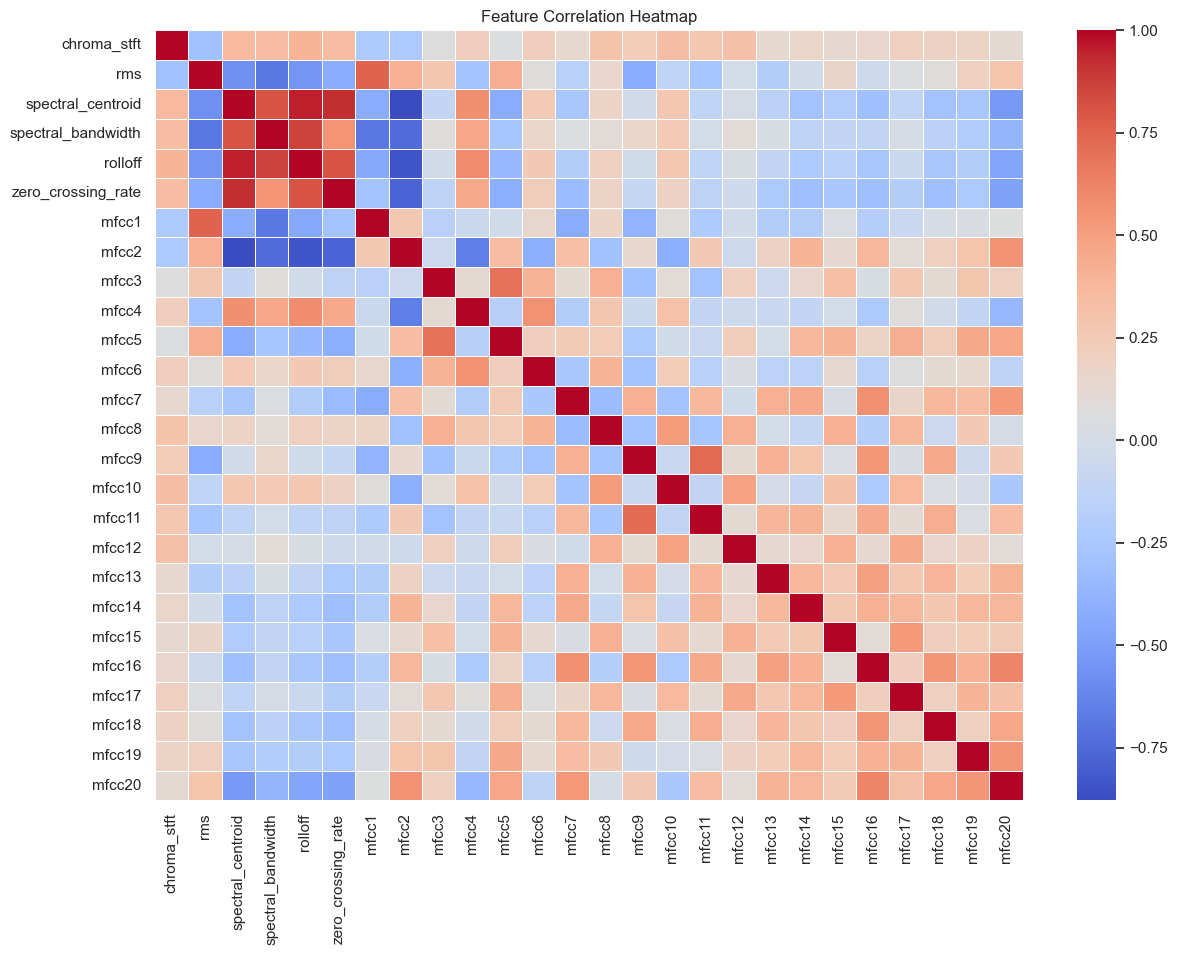

In [16]:
correlation_matrix = df.drop(columns=["LABEL"]).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

- **Strong positive correlation among `spectral_centroid`, `spectral_bandwidth`, and `rolloff`, suggesting they capture similar characteristics of audio.**
- **`MFCC` features show both positive and negative correlations among themselves, meaning they extract different aspects of the sound.**
- **Low correlation between `chroma_stft` and other features, indicating it captures a unique aspect of the audio.**

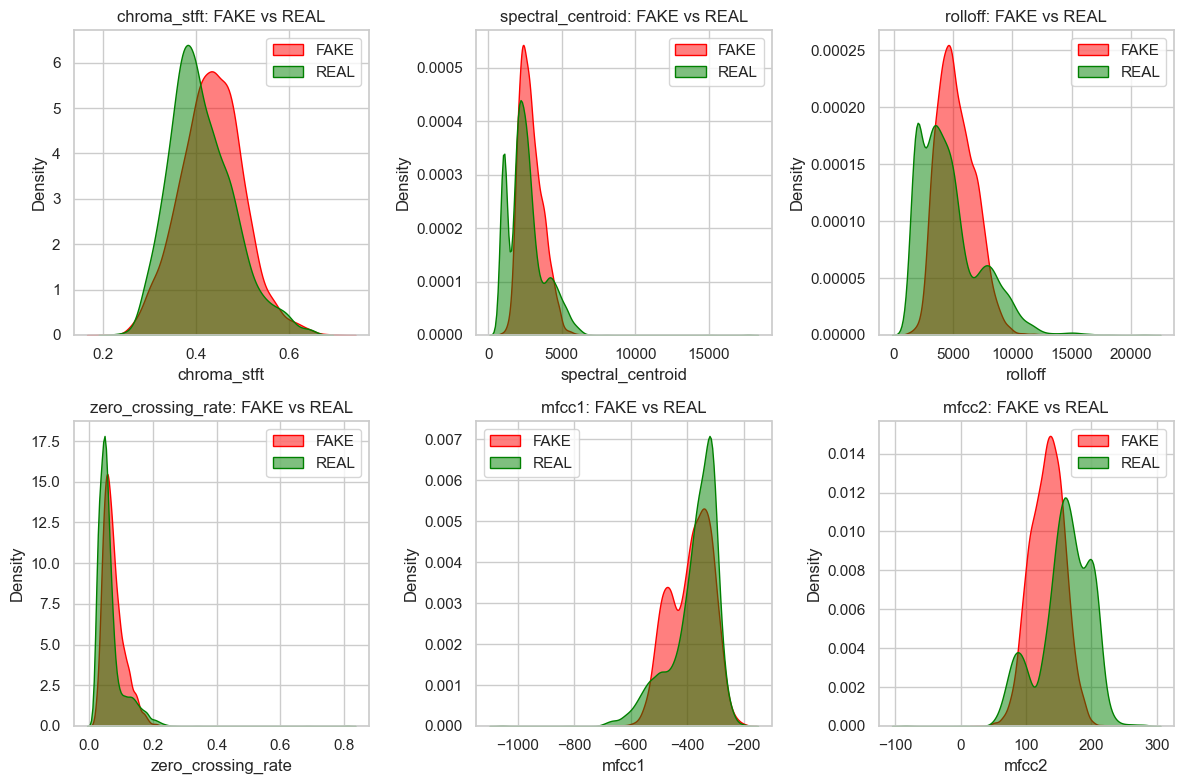

In [17]:
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(df[df["LABEL"] == "FAKE"][feature], label="FAKE", fill=True, color="red", alpha=0.5)
    sns.kdeplot(df[df["LABEL"] == "REAL"][feature], label="REAL", fill=True, color="green", alpha=0.5)
    plt.title(f"{feature}: FAKE vs REAL")
    plt.legend()

plt.tight_layout()
plt.show()

1. **Chroma_stft**
   - FAKE and REAL voice distributions overlap but have noticeable differences.
   - FAKE voices (red) tend to have a slightly higher concentration around 0.45–0.55.
   - REAL voices (green) exhibit a more spread-out distribution, peaking slightly lower.
   - **Possible Insight :** FAKE voices might have higher tonal stability compared to REAL voices.
2. **Spectral Centroid**
   - FAKE voices have a higher concentration of lower spectral centroids (below 5000).
   - REAL voices show a broader range, with more instances extending beyond 5000 Hz.
   - **Possible Insight :** FAKE voices might have a duller or lower-frequency tone, whereas REAL voices tend to have a wider frequency range.
3. **Rolloff**
   - FAKE voices exhibit a higher density at lower rolloff frequencies (~4000–6000 Hz).
   - REAL voices are more evenly distributed and extend to higher frequencies.
   - **Possible Insight :** FAKE voices might have less high-frequency content, making them sound smoother or less sharp.
4. **Zero Crossing Rate**
   - Both distributions are highly skewed to the left.
   - FAKE voices have a slightly broader spread, while REAL voices peak at lower ZCR values.
   - **Possible Insight :** FAKE voices might contain more abrupt changes in signal polarity, which can affect their perceived clarity.
5. **MFCC1**
   - FAKE voices have a strong peak around -400, while REAL voices are distributed more broadly.
   - **Possible Insight :** FAKE voices might exhibit a more concentrated spectral shape, potentially due to the nature of synthetic or manipulated speech.
6. **MFCC2**
   - FAKE and REAL voices have clearly separated peaks.
   - FAKE voices cluster around 100–200, while REAL voices peak at lower values (~50–150).
   - **Possible Insight :** This feature might be one of the strongest indicators for differentiating FAKE vs. REAL voices.

**Overall Conclusion**
   - FAKE voices appear to have lower spectral rolloff and centroid values, suggesting they may sound duller or more robotic.
   - MFCC features (especially MFCC2) show significant differences, which may help classify FAKE vs. REAL voices.
   - Zero crossing rate differences suggest that FAKE voices could be less smooth and more abrupt in waveform transitions.

In [18]:
real = df[df['LABEL'] == 'REAL']
fake = df[df['LABEL'] == 'FAKE']

p_values = {}
for feature in df.columns[:-1]: 
    stat, p = ttest_ind(real[feature], fake[feature], equal_var=False)
    p_values[feature] = p

p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])
significant_features = p_values_df[p_values_df['p_value'] < 0.05]
print("Significant Features (p < 0.05):")
print(significant_features)

Significant Features (p < 0.05):
                          p_value
chroma_stft          1.255482e-67
rms                  6.812161e-15
spectral_centroid    5.306269e-74
spectral_bandwidth   3.118181e-96
rolloff              2.509645e-49
zero_crossing_rate   3.000349e-65
mfcc1                6.695210e-16
mfcc2                0.000000e+00
mfcc3                6.127713e-83
mfcc4               2.610493e-236
mfcc6               7.010228e-208
mfcc7                7.667816e-17
mfcc8                2.102201e-55
mfcc9               6.431684e-159
mfcc10              1.167715e-114
mfcc11               4.988613e-48
mfcc12              1.483692e-126
mfcc13               5.113153e-18
mfcc14               2.877686e-19
mfcc15               3.141394e-23
mfcc16               3.076923e-36
mfcc17               9.220652e-08
mfcc18               0.000000e+00
mfcc19              5.049438e-101
mfcc20               5.719213e-12


### Detailed Insights from the t-test Results
The t-test compares the distributions of each feature between FAKE and REAL voices. The p-values indicate whether a feature has a statistically significant difference between the two classes. If p < 0.05, we reject the null hypothesis and conclude that the feature is significantly different between FAKE and REAL voices.

In this case, all listed features have extremely small p-values (<< 0.05), meaning they strongly differentiate FAKE and REAL voices. Below, I break down the insights for each type of feature.

### 1️. Spectral Features (Chroma, RMS, Centroid, Bandwidth, Rolloff, Zero-Crossing Rate)
These features represent the overall frequency and energy characteristics of the audio.

- **`chroma_stft (p = 1.25e-67)`**
  - Measures the strength of different pitch classes in an audio signal.
  - The significant p-value suggests that FAKE and REAL voices have different harmonic structures.
  - FAKE voices might have less harmonic richness due to synthetic artifacts.
- **`rms (p = 6.81e-15)`**
  - Root Mean Square (RMS) measures the energy of the signal.
  - A significant difference suggests FAKE and REAL voices vary in loudness.
  - FAKE voices might have more uniform energy distribution due to synthesis techniques.
- **`spectral_centroid (p = 5.30e-74)`**
  - Represents the center of mass of the spectrum, associated with perceived brightness.
  - The low p-value means that FAKE voices have different spectral distributions than REAL ones.
  - FAKE voices might be brighter (higher centroid) or duller (lower centroid), depending on synthesis artifacts.
- **`spectral_bandwidth (p = 3.12e-96)`**
  - Measures the spread of frequencies around the spectral centroid.
  - A significant difference suggests FAKE and REAL voices have different spectral spreads.
  - FAKE voices might have narrower bandwidths (less variation in frequency).
- **`rolloff (p = 2.50e-49)`**
  - Represents the frequency below which most of the spectral energy is contained.
  - The significant difference suggests that FAKE and REAL voices decay at different frequencies.
  - FAKE voices may have higher rolloff frequencies due to sharper spectral edges.
- **`zero_crossing_rate (p = 3.00e-65)`**
  - Measures how often the signal changes sign (crosses zero), indicating noisiness.
  - A significant difference suggests FAKE voices might have different transient properties.
  - FAKE voices might be smoother (lower zero-crossing rate) or noisier (higher rate), depending on the synthesis method.
### 2️. MFCC Features (MFCC1 – MFCC20)
Mel-Frequency Cepstral Coefficients (MFCCs) capture the timbre of the audio, which is crucial for distinguishing between different types of sounds.

- **Key MFCC Features with Very Low p-values**
  - **`mfcc1 - mfcc20 (all p-values << 0.05)`** indicate that the timbre of FAKE voices is significantly different from REAL voices.
  - **`mfcc2 (p = 0.0)`** and **`mfcc18 (p = 0.0)`** suggest these two features have an extremely strong difference between FAKE and REAL voices.
- **Specific MFCCs with the Lowest p-values**
  - **`mfcc4`** (p = 2.61e-236)
  - **`mfcc6`** (p = 7.01e-208)
  - **`mfcc9`** (p = 6.43e-159)
  - **`mfcc12`** (p = 1.48e-126)
  - **`mfcc19`** (p = 5.05e-101)
- **What This Means :**
  - These MFCCs capture subtle frequency variations that are significantly different between FAKE and REAL voices.
  - FAKE voices may have less natural variation in their frequency content.
  - These features are critical for classification since they capture the most noticeable differences in timbre.
### Final Takeaway
- Every feature analyzed is statistically significant in distinguishing FAKE vs REAL voices.
- Spectral features (e.g., centroid, bandwidth, rolloff) highlight differences in frequency content.
- MFCCs (especially mfcc4, mfcc6, mfcc9, mfcc12, mfcc19) capture major timbre differences between FAKE and REAL voices.
- These insights can be directly used for building a fake voice detection model.

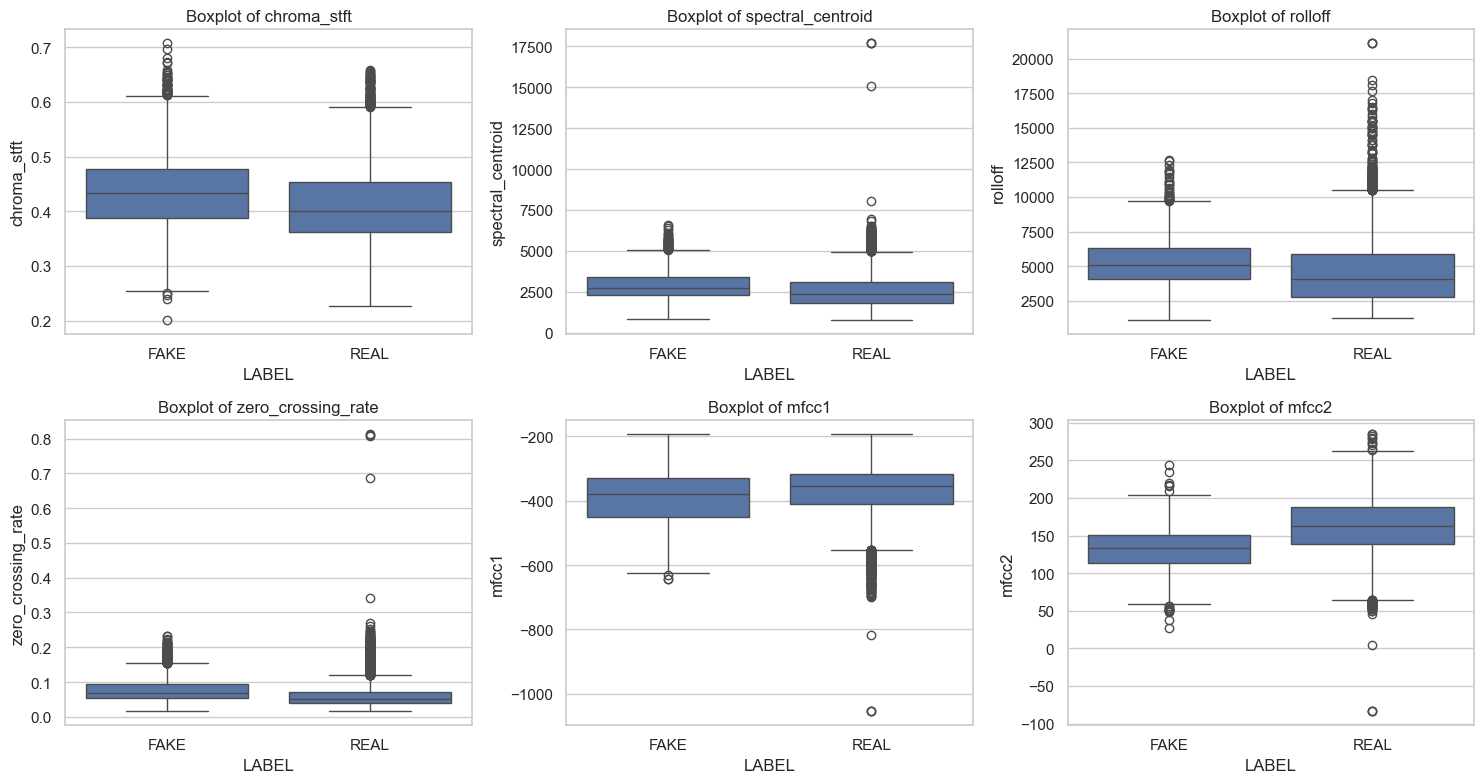

In [19]:
features = ["chroma_stft", "spectral_centroid", "rolloff", "zero_crossing_rate", "mfcc1", "mfcc2"]

plt.figure(figsize=(15, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="LABEL", y=feature, data=df)
    plt.title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

**Boxplots allow us to analyze the distribution, central tendency (median), spread (IQR), and outliers for FAKE and REAL voice samples across different features. Below, I will break down the insights for each feature.**

1. **Chroma_stft (Chromagram Short-Time Fourier Transform)**
   - The distributions for FAKE and REAL voices appear similar, but FAKE voices seem to have slightly lower chroma_stft values on average.
   - The median for FAKE is slightly lower than for REAL.
   - FAKE voices have more spread towards lower values, possibly indicating less tonal richness.

***FAKE voices may have less tonal variation or reduced harmonic content, which is a common issue in synthetic speech.***

2. **Spectral Centroid**
   - The median values of FAKE and REAL are very close.
   - However, FAKE voices show less variability, while REAL voices have more extreme outliers (higher centroid values).
   - FAKE voices have a more compact range of spectral centroid values.

***FAKE voices may lack high-frequency components or have a more controlled spectral balance due to synthetic processing.***

***REAL voices exhibit more natural variations in brightness, possibly due to authentic articulation and natural speech variations.***

3. **Spectral Rolloff**
   - The median values are close, but FAKE voices have a slightly lower rolloff.
   - REAL voices have higher rolloff values with more extreme outliers, indicating wider spectral coverage.
   
***FAKE voices may have more low-frequency dominance, meaning less high-frequency energy.***

***REAL voices may have wider spectral distributions, leading to more natural speech characteristics.***
 
4. **Zero Crossing Rate (ZCR)**
   - Both distributions have similar medians, but FAKE voices show less variation.
   - FAKE voices have fewer extreme outliers, suggesting less transient activity.
   - REAL voices show a wider range of zero-crossing values, indicating more variability in noisiness.

***FAKE voices may lack natural high-frequency transients, making them smoother and more uniform.***

***REAL voices tend to have more natural noise fluctuations, consistent with human speech dynamics.***

5. **MFCC1 (Mel-Frequency Cepstral Coefficient 1)**
   - FAKE voices have a slightly higher median MFCC1 value.
   - REAL voices have a wider spread and more extreme low values.
   - There are many extreme outliers in REAL voices, suggesting greater natural variation.

***FAKE voices may have less variation in vocal tract characteristics, making them more synthetic.***

***REAL voices exhibit greater natural diversity in speech articulation.***

6. **MFCC2 (Mel-Frequency Cepstral Coefficient 2)**
   - The median MFCC2 is noticeably higher in REAL voices.
   - FAKE voices have a lower median and a smaller range.
   - REAL voices have more outliers, meaning greater natural variability.

***FAKE voices may lack natural resonance variations, making them more monotonous.***

***REAL voices exhibit more natural frequency shifts, consistent with authentic speech articulation.***


1. FAKE voices tend to have lower variability across most spectral and cepstral features.
   - Less variation in chroma_stft, spectral centroid, rolloff, and MFCCs suggests that FAKE voices might lack natural fluctuations in timbre and pitch.
2. FAKE voices may lack high-frequency details.
   - Lower spectral rolloff and spectral centroid suggest that FAKE voices contain fewer high-frequency components, making them sound duller or less crisp.
3. FAKE voices are more uniform and less noisy.
   - The zero-crossing rate and MFCC features indicate that FAKE voices are smoother, less noisy, and have fewer transients, making them sound less organic.
4. REAL voices have greater dynamic range and more natural variability.
   - Higher spread in spectral features and MFCCs suggests that REAL voices retain natural variations in speech.

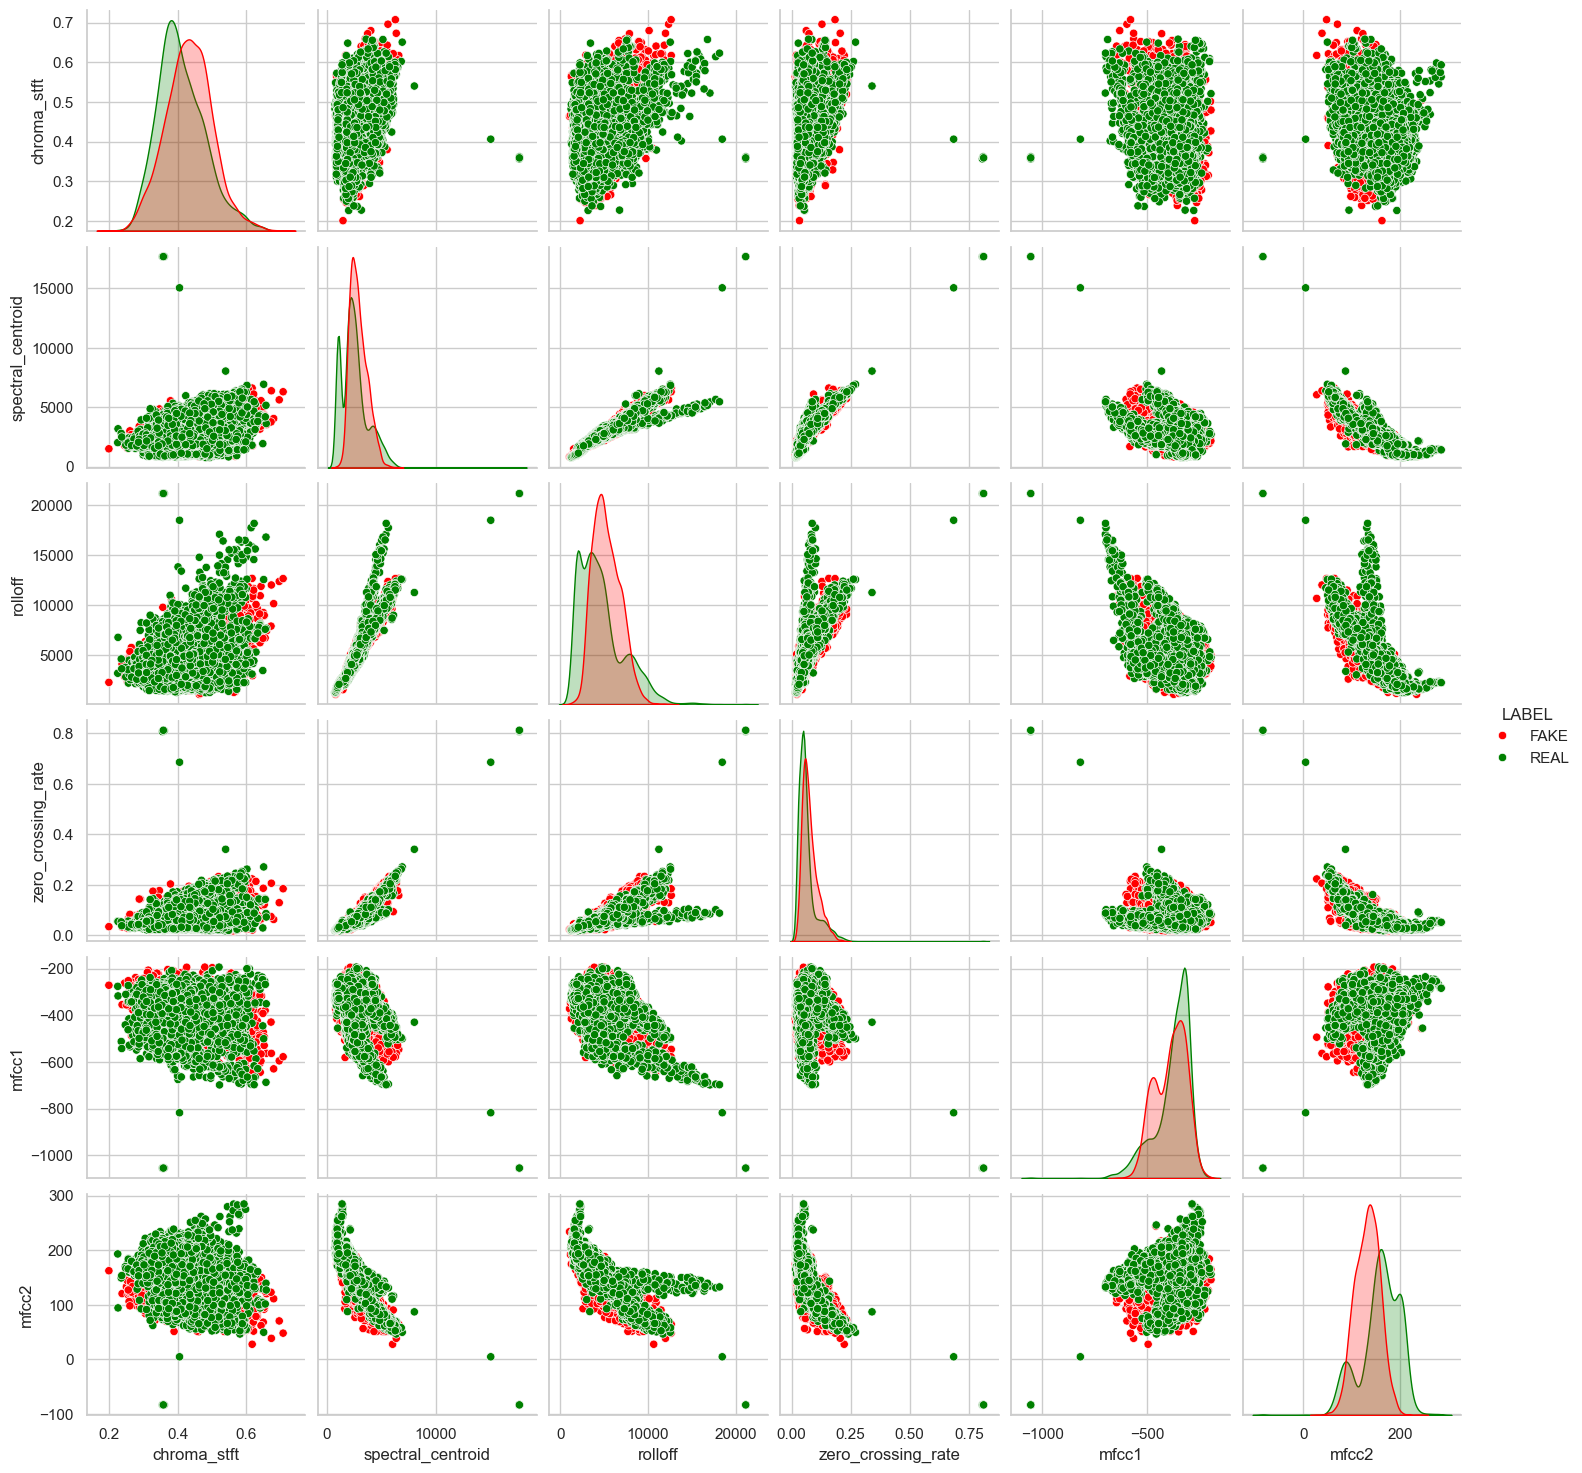

In [20]:
selected_features = ["chroma_stft", "spectral_centroid", "rolloff", "zero_crossing_rate", "mfcc1", "mfcc2", "LABEL"]
sns.pairplot(df[selected_features], hue="LABEL", palette={"REAL": "green", "FAKE": "red"})
plt.show()

This pairplot (scatter plot matrix) helps analyze the relationships between different features in the dataset. The red points represent FAKE voices, while the green points represent REAL voices.

1. **Feature Distributions (Diagonal Plots - KDE & Histograms)**
   - The diagonal plots show the distribution (density) of each feature for FAKE and REAL voices.
   - **Key Observations :**
     1. **`Chroma_stft :`**
        - FAKE and REAL voices have slightly different distributions, with REAL voices tending towards higher chroma_stft values.
     2. **`Spectral Centroid & Spectral Rolloff :`**
        - The distributions are somewhat overlapping, but FAKE voices appear to have less variance.
     3. **`Zero Crossing Rate :`**
        - FAKE voices show lower zero-crossing rate values on average.
     4. **`MFCC1 and MFCC2 :`**
        - FAKE voices have a narrower distribution, while REAL voices spread more widely, indicating more natural variation.

**Insight :**
  - FAKE voices appear more uniform, while REAL voices show greater variability in most features.
  - Some features (e.g., MFCCs, spectral centroid, and rolloff) could be useful for classification.

2. **Feature Relationships (Scatter Plots - Off-Diagonal Plots)**
   - Each scatter plot shows the relationship between two features. If a feature is useful for distinguishing FAKE vs. REAL voices, we would expect FAKE voices (red) to be clustered separately from REAL voices (green).
   - **Observations of Feature Relationships :**
     1. **`Chroma_stft vs. Spectral Centroid & Spectral Rolloff`**
        - The relationship appears linear, with higher spectral centroid/rolloff values corresponding to higher chroma_stft.
        - FAKE and REAL voices overlap, but FAKE voices tend to have lower spectral values.
     2. **`Spectral Centroid vs. Spectral Rolloff`**
        - There is a strong positive correlation, which is expected since both measure frequency energy distribution.
        - However, FAKE voices tend to have lower spectral centroid and rolloff values, indicating a reduction in high-frequency components.
     3. **`Zero Crossing Rate vs. Spectral Features`**
        - FAKE voices generally have lower zero-crossing rates, meaning their waveforms change direction less frequently, making them sound smoother and less noisy.
        - REAL voices exhibit greater variation, reflecting the natural fluctuations in human speech.
     4. **`MFCC1 vs. MFCC2`**
        - FAKE voices cluster more tightly, while REAL voices spread out more.
        - This suggests that FAKE voices might have less diversity in vocal tract characteristics, making them more synthetic.
     5. **`MFCC Features vs. Spectral Features`**
        - FAKE voices tend to stay within a smaller range in spectral and MFCC feature space.
        - REAL voices spread out more, indicating greater variation in articulation and resonance.

**Key Takeaways from the Pairplot**
- FAKE voices tend to have lower spectral centroid and rolloff values, meaning they lack high-frequency content.
- FAKE voices have a lower zero-crossing rate, making them smoother and less noisy.
- FAKE voices show less variation in MFCCs, making them more uniform and synthetic.
- REAL voices exhibit greater natural fluctuations in frequency and spectral characteristics, making them more diverse and realistic.

In [21]:
le = LabelEncoder()
df['LABEL'] = le.fit_transform(df['LABEL'])
df['LABEL']

0        0
1        0
2        0
3        0
4        0
        ..
11773    1
11774    1
11775    1
11776    1
11777    1
Name: LABEL, Length: 11778, dtype: int32

### FAKE : 0 & REAL : 1 

In [22]:
scaler = StandardScaler()
df[['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20']] = scaler.fit_transform(df[['chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20']])

In [23]:
X = df.drop('LABEL', axis=1)
y = df['LABEL']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

# ENSEMBLE MODEL

## 1. BAGGING (RandomForest)

In [25]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Important Feature Extraction

In [26]:
feats_rf = pd.DataFrame(data=rf.feature_importances_, index = X.columns, columns=["Importance"])
important_features_rf = feats_rf[feats_rf["Importance"]>0].index.tolist()
important_features_rf

['chroma_stft',
 'rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

#### Model Training with Important Parameter

In [27]:
X_train_rf = X_train[important_features_rf]
X_test_rf = X_test[important_features_rf]
rf.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=42)

#### Model Evaluation

Train Accuracy :  1.0

Cross Validation Score :  0.9838674979022002
Test Accuracy :  0.9872665534804754
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



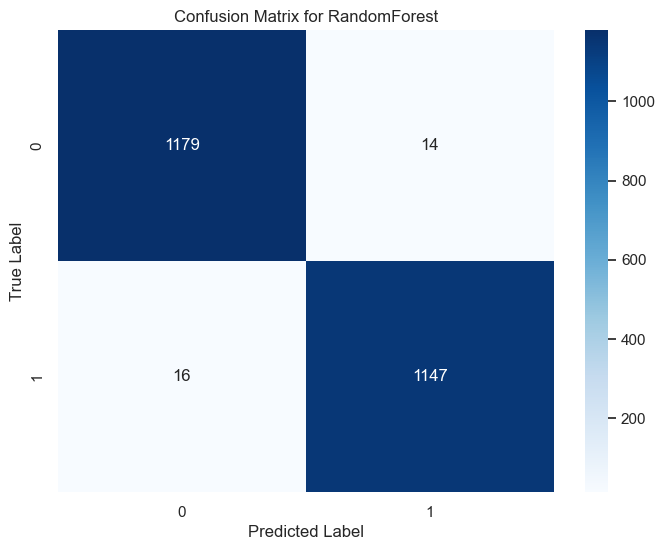

In [28]:
ypred_train = rf.predict(X_train_rf)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(rf,X_train_rf,y_train,cv=5).mean())
ypred_test = rf.predict(X_test_rf)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 2. Boosting

### 2.1. AdaBoost 

In [29]:
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

#### Important Feature Extractions

In [30]:
feats_ab = pd.DataFrame(data=ab.feature_importances_, index = X.columns, columns=["Importance"])
important_features_ab = feats_ab[feats_ab["Importance"]>0].index.tolist()
important_features_ab

['rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

#### Model Training with Important Feature

In [31]:
X_train_ab = X_train[important_features_ab]
X_test_ab = X_test[important_features_ab]
ab.fit(X_train_ab, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

#### Model Evaluation

Train Accuracy :  0.9492676714073445

Cross Validation Score :  0.930481621021924
Test Accuracy :  0.9384550084889643
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1193
           1       0.94      0.93      0.94      1163

    accuracy                           0.94      2356
   macro avg       0.94      0.94      0.94      2356
weighted avg       0.94      0.94      0.94      2356



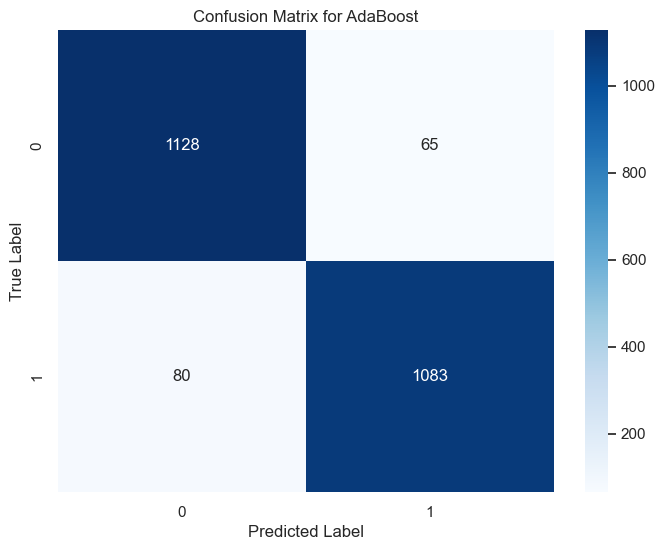

In [32]:
ypred_train = ab.predict(X_train_ab)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(ab,X_train_ab,y_train,cv=5).mean())
ypred_test = ab.predict(X_test_ab)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for AdaBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 2.2. Gradient Boosting (GBM)

In [33]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

#### Important Feature Extractions

In [34]:
feats_gb = pd.DataFrame(data=gb.feature_importances_,index = X.columns,columns=["Importance"])
important_features_gb = feats_gb[feats_gb["Importance"]>0].index.tolist()
important_features_gb

['chroma_stft',
 'rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

#### Model Training with Important Features

In [35]:
X_train_gb = X_train[important_features_gb]
X_test_gb = X_test[important_features_gb]
gb.fit(X_train_gb, y_train)

GradientBoostingClassifier(random_state=42)

#### Model Evaluation

Train Accuracy :  0.9811080450010613

Cross Validation Score :  0.9682658940005744
Test Accuracy :  0.9711375212224108
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1193
           1       0.98      0.96      0.97      1163

    accuracy                           0.97      2356
   macro avg       0.97      0.97      0.97      2356
weighted avg       0.97      0.97      0.97      2356



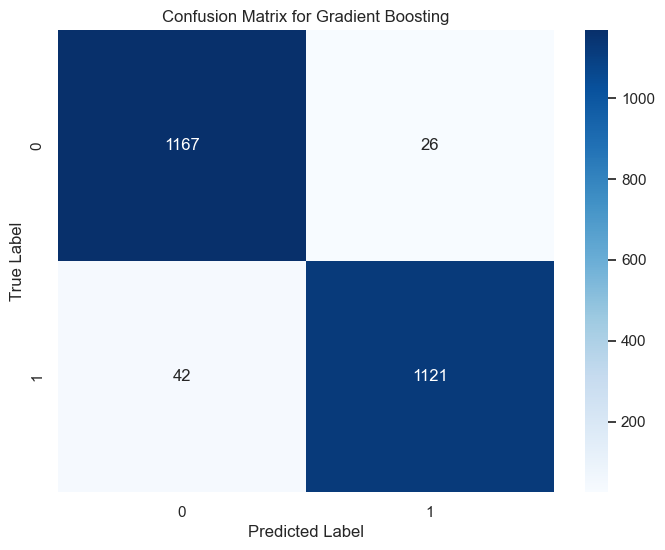

In [36]:
ypred_train = gb.predict(X_train_gb)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(gb,X_train_gb,y_train,cv=5).mean())
ypred_test = gb.predict(X_test_gb)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 2.3. XGBoost

In [37]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

#### Important Feature Extractions

In [38]:
feats_xgb = pd.DataFrame(data=xgb.feature_importances_, 
                        index = X.columns, 
                        columns=["Importance"])
important_features_xgb = feats_xgb[feats_xgb["Importance"]>0].index.tolist()
important_features_xgb

['chroma_stft',
 'rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

#### Model Training with Important Features

In [39]:
X_train_xgb = X_train[important_features_xgb]
X_test_xgb = X_test[important_features_xgb]
xgb.fit(X_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

#### Model Evaluation

Train Accuracy :  0.9997877308427086

Cross Validation Score :  0.987263680751491
Test Accuracy :  0.9898132427843803
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



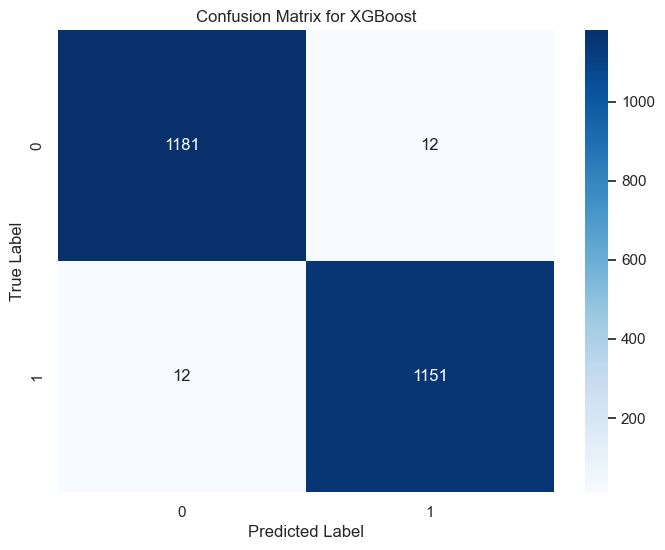

In [40]:
ypred_train = xgb.predict(X_train_xgb)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(xgb,X_train_xgb,y_train,cv=5).mean())
ypred_test = xgb.predict(X_test_xgb)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 2.4. LightGBM

In [41]:
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4726, number of negative: 4696
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 9422, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501592 -> initscore=0.006368
[LightGBM] [Info] Start training from score 0.006368


LGBMClassifier(random_state=42)

#### Important Feature Extractions

In [42]:
feats_lgbm = pd.DataFrame(data=lgbm.feature_importances_, 
                        index = X.columns, 
                        columns=["Importance"])
important_features_lgbm = feats_lgbm[feats_lgbm["Importance"]>0].index.tolist()
important_features_lgbm

['chroma_stft',
 'rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

#### Model Training with Important Features

In [43]:
X_train_lgbm = X_train[important_features_lgbm]
X_test_lgbm = X_test[important_features_lgbm]
lgbm.fit(X_train_lgbm, y_train)

[LightGBM] [Info] Number of positive: 4726, number of negative: 4696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 9422, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501592 -> initscore=0.006368
[LightGBM] [Info] Start training from score 0.006368


LGBMClassifier(random_state=42)

#### Model Evaluation

Train Accuracy :  1.0
[LightGBM] [Info] Number of positive: 3781, number of negative: 3756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501658 -> initscore=0.006634
[LightGBM] [Info] Start training from score 0.006634
[LightGBM] [Info] Number of positive: 3780, number of negative: 3757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501526 -> initscore=0.006103
[LightGBM] [Info] Start training from score 0.006103


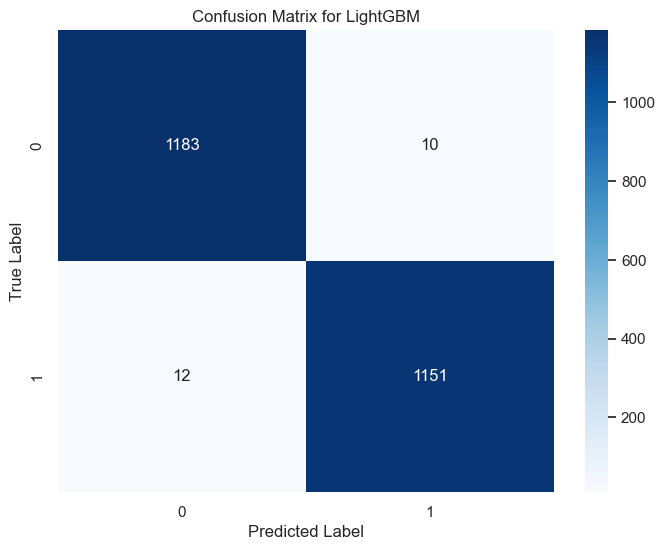

In [44]:
ypred_train = lgbm.predict(X_train_lgbm)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(lgbm,X_train_lgbm,y_train,cv=5).mean())
ypred_test = lgbm.predict(X_test_lgbm)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for LightGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 2.5. CatBoost

In [47]:
catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0, random_state=42)
catboost.fit(X_train, y_train)

#### Important Feature Extractions

In [48]:
feats_catboost = pd.DataFrame(data=catboost.feature_importances_, 
                        index = X.columns, 
                        columns=["Importance"])
important_features_catboost = feats_catboost[feats_catboost["Importance"]>0].index.tolist()
important_features_catboost

['chroma_stft',
 'rms',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

#### Model Training with Important Features

In [49]:
X_train_catboost = X_train[important_features_catboost]
X_test_catboost = X_test[important_features_catboost]
catboost.fit(X_train_catboost, y_train)

#### Model Evaluation

Train Accuracy :  0.9952239439609425

Cross Validation Score :  0.986945265730682
Test Accuracy :  0.9876910016977929
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1193
           1       0.99      0.99      0.99      1163

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



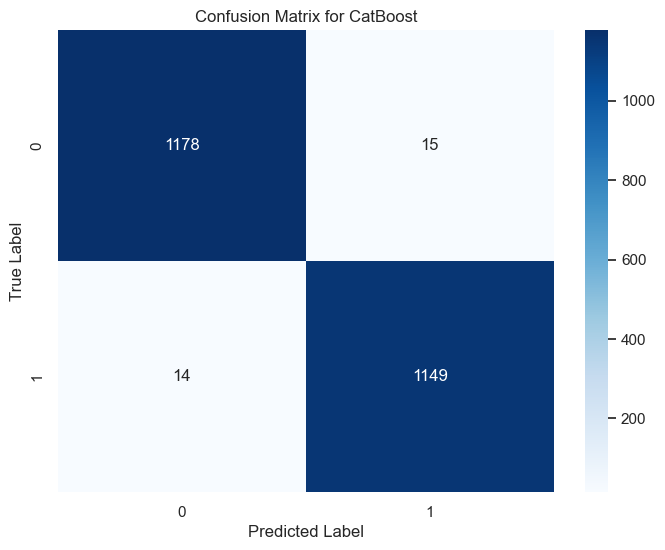

In [50]:
ypred_train = catboost.predict(X_train_catboost)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(catboost,X_train_catboost,y_train,cv=5).mean())
ypred_test = catboost.predict(X_test_catboost)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for CatBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 3. Stacking

In [51]:
# Define Base Learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
]

# Meta-learner: Logistic Regression
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(), cv=5)

stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4726, number of negative: 4696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 9422, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501592 -> initscore=0.006368
[LightGBM] [Info] Start training from score 0.006368
[LightGBM] [Info] Number of positive: 3781, number of negative: 3756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501658 -> initscore=0.006634
[LightGBM] [Info] Start training from score 0.006634
[LightGBM] [Info] Numb

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lgbm', LGBMClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

Train Accuracy :  1.0
[LightGBM] [Info] Number of positive: 3781, number of negative: 3756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 7537, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501658 -> initscore=0.006634
[LightGBM] [Info] Start training from score 0.006634
[LightGBM] [Info] Number of positive: 3025, number of negative: 3004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 6029, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501742 -> initscore=0.006966
[LightGBM] [Info] Start training from score 0.006966


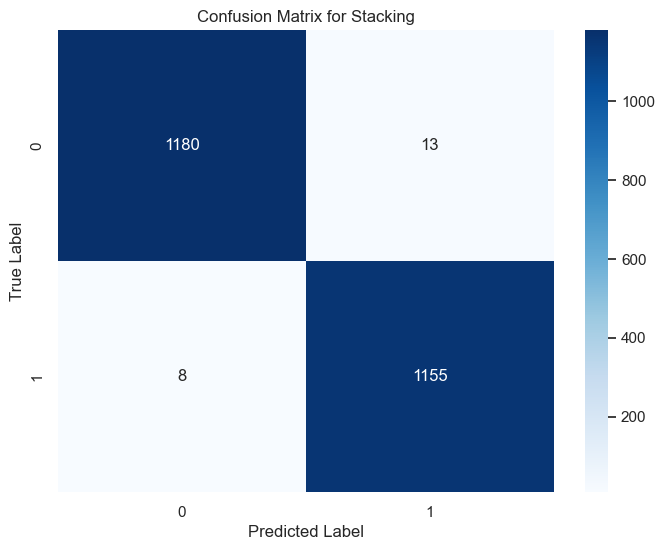

In [52]:
ypred_train = stacking_model.predict(X_train)
print("Train Accuracy : ",accuracy_score(y_train,ypred_train))
print("\nCross Validation Score : ",cross_val_score(stacking_model,X_train,y_train,cv=5).mean())
ypred_test = stacking_model.predict(X_test)
print("Test Accuracy : ",accuracy_score(y_test,ypred_test))
print(classification_report(y_test, ypred_test))
conf_matrix = confusion_matrix(y_test, ypred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for Stacking')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()